# Imports

## Libraries

In [61]:
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import seaborn as sns
from shapely.ops import unary_union
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from benfordslaw import benfordslaw
from shapely.geometry import Point
import matplotlib.pyplot as plt

## Data

In [62]:
prov_gdf = gpd.read_file("../data/it_provinces_shapes.geojson", driver='geojson')
provinces_df = pd.read_csv("../data/provinces.csv", skipfooter=1)
provinces_gdf = gpd.read_file("../data/provinces_gdf.geojson", driver='geojson')

# Plotting the Data

## Population

### Boxplot of province populations

The Mean Province Population is 570758.0


<AxesSubplot:ylabel='Population'>

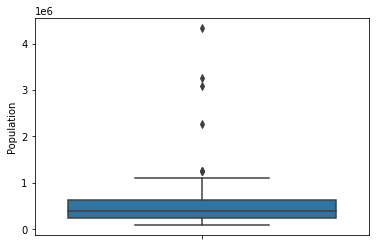

In [63]:
# most regions have around half a million
print(f"The Mean Province Population is {round(provinces_gdf.Population.mean(),0)}")
sns.boxplot(data = provinces_gdf, y='Population')

### Boxplot of province populations by Macroregion

<AxesSubplot:xlabel='Macroregion', ylabel='Population'>

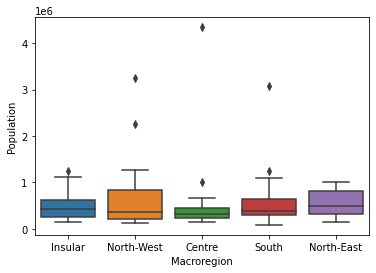

In [64]:
# all regions have major outliers except for Insular (Islands) and the North-East
sns.boxplot(data = provinces_gdf, x='Macroregion', y='Population')

### Simple Population Choropleth

<AxesSubplot:>

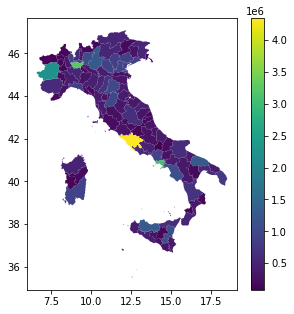

In [65]:
provinces_gdf.plot(column = 'Population', figsize=(5, 5), legend=True)

### Cartograms

#### Simple Cartogram

<GeoAxesSubplot:>

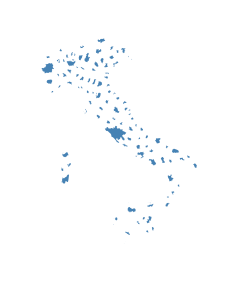

In [66]:
gplt.cartogram(provinces_gdf, scale='Population', projection=gcrs.AlbersEqualArea(), figsize=(5,5), )

#### Cartogram / Choropleth Map

<GeoAxesSubplot:>

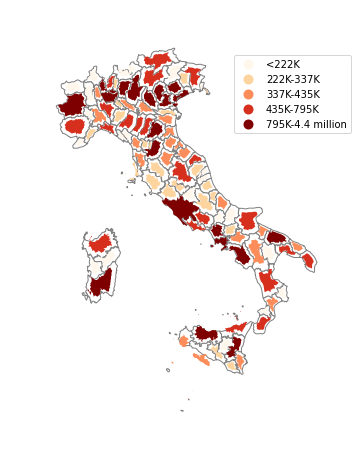

In [67]:
scheme = mc.Quantiles(provinces_gdf['Population'], k=5)
ax1 = gplt.cartogram(
    provinces_gdf, scale='Population', projection=gcrs.AlbersEqualArea(), figsize=(10, 8),
    legend=True, legend_kwargs={'bbox_to_anchor': (1, 0.9)}, legend_var='hue',
    hue='Population', scheme=scheme, cmap='OrRd', limits=(0.6, 1.1),
    legend_labels=[
        '<222K', '222K-337K', '337K-435K',
        '435K-795K', '795K-4.4 million'
    ]
)
gplt.polyplot(provinces_gdf, facecolor='white', edgecolor='grey', ax=ax1)

### How many provinces does it take to cover half of the population

In [68]:
provinces_gdf.Population.sum()

60500383

In [69]:
## sort by population
### iteratively add them until you have 30.2 million

In [70]:
provinces_gdf_pop_sort = provinces_gdf.sort_values(by='Population', ascending=False)

In [71]:
pop_sum = 0
counter = 0
total_pop = provinces_gdf.Population.sum()
for pop in provinces_gdf_pop_sort['Population']:
    if pop_sum < (total_pop / 2):
        pop_sum += pop
        counter += 1
    else:
        break

In [72]:
# you only need 22 provinces to reach half of the italian population
print(counter)
print(provinces_gdf.shape[0])

22
106


#### Displaying most populous regions only

<GeoAxesSubplot:>

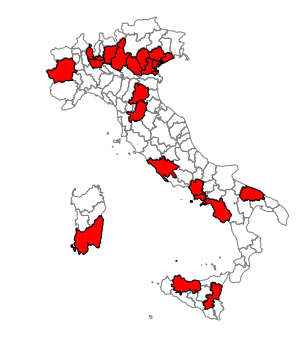

In [73]:
ax2 =  gplt.polyplot(provinces_gdf_pop_sort, projection=gcrs.AlbersEqualArea(), edgecolor = 'gray')
gplt.polyplot(
    provinces_gdf_pop_sort[0:21], projection=gcrs.AlbersEqualArea(), ax=ax2, facecolor='red'
)

#### What percent of the land area is needed to cover half of the population

In [81]:
# You only need 22.2 percent of the land to cover 50 percent of the population of Italy!
pct_of_land_half_pop = round(provinces_gdf_pop_sort[0:21].Area.sum() / \
                             provinces_gdf_pop_sort.Area.sum(), 3) * 100
print(pct_of_land_half_pop)

22.2


## Macroregions' Population

In general, Italy can be divided into 5 regions: North-East, North-West, Centre, South, and Insular (Islands). I would like to see how these regions appear on the map

In [424]:
macro_geometries = provinces_gdf.dissolve(by='Macroregion', aggfunc='sum')

### Cartogram

<GeoAxesSubplot:>

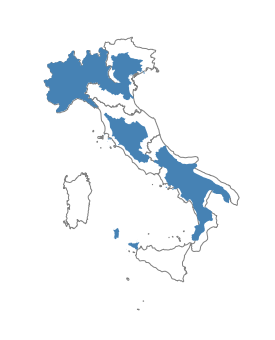

In [88]:
ax3 = gplt.cartogram(macro_geometries, scale='Population', projection=gcrs.AlbersEqualArea())
gplt.polyplot(macro_geometries, facecolor='white', edgecolor='grey', ax=ax3)

### Choropleth

<AxesSubplot:>

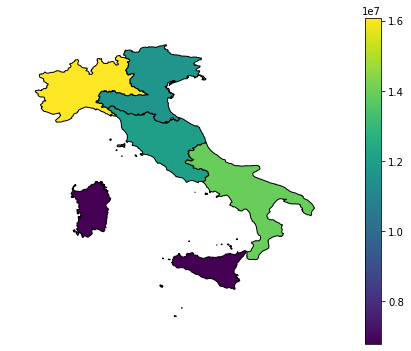

In [89]:
gplt.choropleth(macro_geometries, hue='Population', legend=True)

## Centroids

### Calculate centroid for each region in italy 
https://medium.com/@sumit.arora/plotting-weighted-mean-population-centroids-on-a-country-map-22da408c1397

- Steps to getting the population weighted mean centroid
    - find centroid for each province 
    - group the provinces into megaregions / whole of italy 
    - assign a weight (i.e.: the population) to each province
    - calculate weighted [longitude, latitude] 2-D point inside a megaregion / the country 
    - plot results

In [90]:
# the center of each province (since we don't have any more granular data)
provinces_gdf['Centroid_lat'] = [list(provinces_gdf.geometry[x].centroid.coords)[0][0] 
                                 for x in range(len(provinces_gdf))]
provinces_gdf['Centroid_lon'] = [list(provinces_gdf.geometry[x].centroid.coords)[0][1] 
                                 for x in range(len(provinces_gdf))]

#### Calculate mean centroid for each Region

In [211]:
# ynumerator = latitude multiplied by population
# xnumerator =  longitude multiplied by population 
## divide sum of x/y numberator by the sum of all weights in the megaregion/all of italy 

In [212]:
# so we need all of the weights before we start aggreggating the centroids

In [285]:
provinces_pop_sum = provinces_gdf.groupby('Region')['Population'].sum().to_dict()

In [288]:
# finding numerators for each region
weighted_lat_sum = {key:0 for key in provinces_pop_sum.keys()}
weighted_lon_sum = {key:0 for key in provinces_pop_sum.keys()}
for idx, x in provinces_gdf.iterrows():
    region = x['Region']
#     region_pop = province_pop_sums[region]
    
    weighted_lat_sum[region] += x['Centroid_lat'] * x['Population']
    weighted_lon_sum[region] += x['Centroid_lon'] * x['Population']

#multiply each value by the number of provinces in that region
province_prov_counts = provinces_gdf.groupby('Region')['Population'].count().to_dict()

for key, value in province_prov_counts.items():
    province_pop_sums[key] = province_pop_sums[key] * value
#weighted_lon_sum[key] = weighted_lon_sum[key] * value

In [302]:
# finding weighted lat and long for each region
weighted_mean_lat_lon = {key:[] for key in provinces_pop_sum.keys()}
for key, value in provinces_pop_sum.items():
#     print(f"Key = {key}, Value = {value}")
    weighted_mean_lat_lon[key] = [weighted_lat_sum[key] / value, weighted_lon_sum[key] / value]
#     weighted_mean_lat_lon[key].append(weighted_lon_sum[key] / value)

In [290]:
weighted_mean_lat_lon['Abruzzo']

[13.950052455232992, 42.28685375297654]

In [291]:
region_weighted_centroid_df = pd.DataFrame.from_dict(weighted_mean_lat_lon, orient='index', 
                                                     columns=['Lat_weighted_centroid', "Lon_weighted_centroid"])

In [292]:
region_weighted_centroid_df['Centroid_Coords'] = list(zip(region_weighted_centroid_df['Lat_weighted_centroid'], 
                                                   region_weighted_centroid_df['Lon_weighted_centroid']))
region_weighted_centroid_df['geometry'] = [Point(x) for x in region_weighted_centroid_df['Centroid_Coords']]
region_weighted_centroid_gdf = gpd.GeoDataFrame(region_weighted_centroid_df)

<AxesSubplot:>

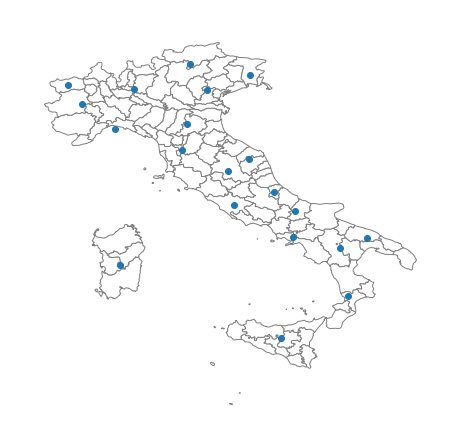

In [295]:
ax5 = region_weighted_centroid_gdf.plot(figsize=(8,8))
gplt.polyplot(provinces_gdf, facecolor='white', edgecolor='grey', ax=ax5, figsize=(8,8))

#### Attempt with all of italy

In [299]:
provinces_gdf['Country'] = 'Italy'

In [320]:
provinces_gdf.head()

,Code,name,Province,Region,Macroregion,Population (2019)[3],Area(km²),Density(p/km²),Population,Area,Density,geometry,Centroid_lat,Centroid_lon,Country,Lat_times_weight,Lon_times_weight
0,AG,Agrigento,Agrigento,Sicily,Insular,"434,870","3,053",144,434870,3053,144,"MULTIPOLYGON (((12.62176 35.50975, 12.62127 35...",13.504662,37.432912,Italy,5.872772e+06,1.627845e+07
1,AL,Alessandria,Alessandria,Piedmont,North-West,"421,284","3,559",119,421284,3559,119,"POLYGON ((8.40472 45.20452, 8.49710 45.19799, ...",8.662525,44.831472,Italy,3.649383e+06,1.888678e+07
2,AN,Ancona,Ancona,Marche,Centre,"471,228","1,963",241,471228,1963,241,"POLYGON ((13.17721 43.75152, 13.25327 43.70319...",13.154161,43.504727,Italy,6.198609e+06,2.050065e+07
3,AO,Aoste,Aosta,Aosta Valley,North-West,"125,666","3,261",39,125666,3261,39,"POLYGON ((7.02208 45.92526, 7.06694 45.89022, ...",7.370982,45.730169,Italy,9.262818e+05,5.746727e+06
4,AP,Ascoli Piceno,Ascoli Piceno,Marche,Centre,"207,179","1,228",170,207179,1228,170,"POLYGON ((13.85349 43.06736, 13.86541 43.00731...",13.551915,42.888788,Italy,2.807672e+06,8.885656e+06


In [307]:
provinces_gdf['Lat_times_weight'] = provinces_gdf['Centroid_lat'] * provinces_gdf['Population']
provinces_gdf['Lon_times_weight'] = provinces_gdf['Centroid_lon'] * provinces_gdf['Population']

In [308]:
# provinces_gdf_country_sum = provinces_gdf.groupby('Country')['Population', 'Lat_times_weight', 'Lon_times_weight'].sum()

In [337]:
provinces_gdf_country_sum = provinces_gdf.groupby('Country')['Population'].sum()

In [338]:
provinces_gdf_country_sum

Country
Italy    60500383
Name: Population, dtype: int64

In [332]:
provinces_gdf_country_sum['Lat_centroid'] = provinces_gdf_country_sum['Lat_times_weight'] / \
                                                provinces_gdf_country_sum['Population']
provinces_gdf_country_sum['Lon_centroid'] = provinces_gdf_country_sum['Lon_times_weight'] / \
                                                provinces_gdf_country_sum['Population']

KeyError: 'Lat_times_weight'

In [333]:
provinces_gdf_country_sum['Centroid_Coords'] = list(zip(provinces_gdf_country_sum['Lat_centroid'], 
                                                   provinces_gdf_country_sum['Lon_centroid']))
provinces_gdf_country_sum['geometry'] = [Point(x) for x in provinces_gdf_country_sum['Centroid_Coords']]

KeyError: 'Lat_centroid'

In [312]:
type(provinces_gdf_country_sum)

pandas.core.frame.DataFrame

In [313]:
provinces_gdf_country_sum_gdf = gpd.GeoDataFrame(provinces_gdf_country_sum, geometry='geometry')

In [319]:
# values are slightly different than previous approach
provinces_gdf_country_sum_gdf.head(2)

,Population,Lat_times_weight,Lon_times_weight,Lat_centroid,Lon_centroid,Centroid_Coords,geometry
Country,,,,,,,
Italy,60500383,7.297516e+08,2.597829e+09,12.061933,42.939056,"(12.061933242704367, 42.93905581590078)",POINT (12.06193 42.93906)


In [317]:
italy_geometry = provinces_gdf.dissolve(by='Country')

In [330]:
geo_center_of_italy = italy_geometry.centroid
geo_center_of_italy

Country
Italy    POINT (12.07191 42.78643)
dtype: geometry

<AxesSubplot:>

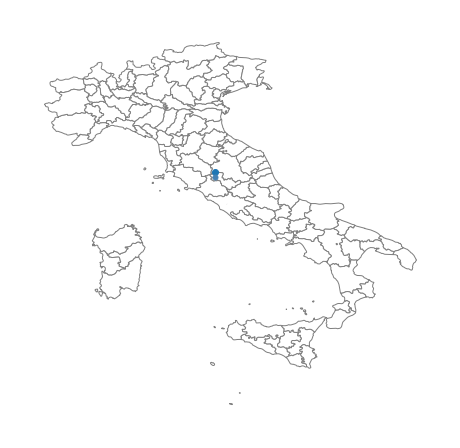

In [329]:
ax5 = provinces_gdf_country_sum_gdf.plot(figsize=(8,8))
# italy_geometry.plot(geometry = 'Geographic_center', ax=ax5, figsize=(8,8))
gplt.pointplot(geo_center_of_italy, ax=ax5)
gplt.polyplot(provinces_gdf, facecolor='white', edgecolor='grey', ax=ax5, figsize=(8,8))

#### Previously here

In [297]:
provinces_gdf_region_sum['Lat_times_weight'] = provinces_gdf_region_sum['Centroid_lat'] * provinces_gdf_region_sum['Population']
provinces_gdf_region_sum['Lon_times_weight'] = provinces_gdf_region_sum['Centroid_lon'] * provinces_gdf_region_sum['Population']

KeyError: 'Centroid_lat'

In [447]:
provinces_data_gdf_region_sum['Lat_centroid'] = provinces_data_gdf_region_sum['Lat_times_weight'] / \
                                                provinces_data_gdf_region_sum['Population']
provinces_data_gdf_region_sum['Lon_centroid'] = provinces_data_gdf_region_sum['Lon_times_weight'] / \
                                                provinces_data_gdf_region_sum['Population']

In [448]:
provinces_data_gdf_region_sum['Centroid_Coords'] = list(zip(provinces_data_gdf_region_sum['Lat_centroid'], 
                                                   provinces_data_gdf_region_sum['Lon_centroid']))
provinces_data_gdf_region_sum['geometry'] = [Point(x) for x in provinces_data_gdf_region_sum['Centroid_Coords']]

In [450]:
type(provinces_data_gdf_region_sum)

pandas.core.frame.DataFrame

In [453]:
provinces_data_gdf_region_sum_gdf = gpd.GeoDataFrame(provinces_data_gdf_region_sum, geometry='geometry')

In [454]:
provinces_data_gdf_region_sum_gdf.head(2)

,Population,Lat_times_weight,Lon_times_weight,Lat_centroid,Lon_centroid,Centroid_Coords,geometry
Region,,,,,,,
Abruzzo,1311580.0,1.829661e+07,5.546259e+07,13.950052,42.286854,"(13.950052455232992, 42.28685375297654)",POINT (13.95005 42.28685)
Aosta Valley,125666.0,9.262818e+05,5.746727e+06,7.370982,45.730169,"(7.37098173797981, 45.730168877636494)",POINT (7.37098 45.73017)


In [460]:
region_geometries = provinces_data_gdf.dissolve(by='Region')

#### Plot

<AxesSubplot:>

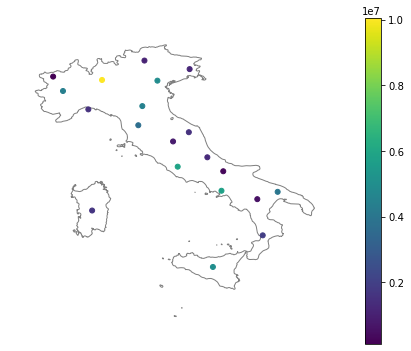

In [537]:
ax5 = gplt.pointplot(provinces_data_gdf_region_sum_gdf, hue='Population', legend=True)
gplt.polyplot(region_geometries, facecolor='white', edgecolor='grey', ax=ax5)

### Calculating Centroid for Italy

In [475]:
provinces_gdf['Country'] = 'Italy'

In [476]:
provinces_gdf_italy_sum = provinces_gdf.groupby('Country')['Population', 'Lat_times_weight', 'Lon_times_weight'].sum()

In [477]:
provinces_gdf_italy_sum['Lat_centroid'] = provinces_gdf_italy_sum['Lat_times_weight'] / \
                                                provinces_gdf_italy_sum['Population']
provinces_gdf_italy_sum['Lon_centroid'] = provinces_gdf_italy_sum['Lon_times_weight'] / \
                                                provinces_gdf_italy_sum['Population']

In [478]:
provinces_gdf_italy_sum['Centroid_Coords'] = list(zip(provinces_gdf_italy_sum['Lat_centroid'], 
                                                   provinces_gdf_italy_sum['Lon_centroid']))
provinces_gdf_italy_sum['geometry'] = [Point(x) for x in provinces_gdf_italy_sum['Centroid_Coords']]

In [479]:
provinces_gdf_italy_sum_gdf = gpd.GeoDataFrame(provinces_gdf_italy_sum, geometry='geometry')

In [480]:
provinces_gdf_italy_sum_gdf.head(2)

,Population,Lat_times_weight,Lon_times_weight,Lat_centroid,Lon_centroid,Centroid_Coords,geometry
Country,,,,,,,
Italy,60500383,7.297516e+08,2.597829e+09,12.061933,42.939056,"(12.061933242704367, 42.93905581590078)",POINT (12.06193 42.93906)


In [481]:
italy_geometry = provinces_gdf.dissolve(by='Country')

In [482]:
italy_geo_centroid = italy_geometry.geometry.centroid

#### Plot

In [ ]:
ax12 = macro_geo_center_gdf.plot(color='black', figsize=(8,8))
provinces_gdf_macroregion_sum_gdf.plot(figsize=(8,8), ax=ax12, color='green')
gplt.polyplot(macro_geometries, facecolor='white', edgecolor='grey', ax=ax12, figsize=(8,8))

<AxesSubplot:>

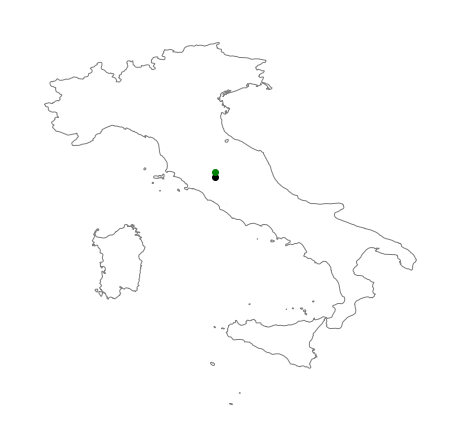

In [486]:
ax6 = italy_geo_centroid.plot(color='black', figsize=(8,8))
provinces_gdf_italy_sum_gdf.plot(ax=ax6, color='green', figsize=(8,8))
gplt.polyplot(italy_geometry, facecolor='white', edgecolor='grey', ax=ax6, figsize=(8,8))

##### Find which region this point lands in

In [498]:
italy_geo_center_point = italy_geo_centroid.geometry[0]
italy_pop_centroid = provinces_gdf_italy_sum_gdf.geometry[0]

In [502]:
# the mean population center of italy is within perugia
for index,x in provinces_gdf.iterrows():
    if x['Macroregion'] == 'Centre':
        if italy_geo_center_point.within(x['geometry']):
            print(f"Geographic center of italy is in the province of: {x['name']}")
        if italy_pop_centroid.within(x['geometry']):
            print(f"Population center of italy is in the province of: {x['name']}")

Population center of italy is in the province of: Perugia
Geographic center of italy is in the province of: Terni


In [504]:
terni_gdf = provinces_gdf[provinces_gdf['Province'] == 'Terni']
perugia_gdf = provinces_gdf[provinces_gdf['Province'] == 'Perugia']

<AxesSubplot:>

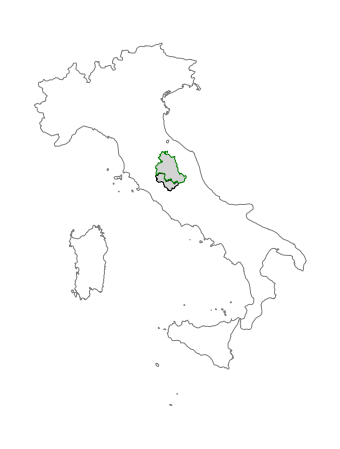

In [515]:
# plotting the regions too
ax6 = gplt.polyplot(italy_geometry, facecolor='white', edgecolor='grey', figsize=(8,8))
italy_geo_centroid.plot(color='black', figsize=(8,8), ax=ax6)
terni_gdf.plot(ax=ax6, color='lightgrey', edgecolor = 'black', figsize=(8,8))
perugia_gdf.plot(ax=ax6, color='lightgrey', edgecolor = 'green', figsize=(8,8))
# provinces_gdf_italy_sum_gdf.plot(ax=ax6, color='green', figsize=(8,8))
# ax6 = gplt.polyplot(italy_geometry, facecolor='white', edgecolor='grey', ax=ax6, figsize=(8,8))

#### Megaregions Centroids

In [444]:
provinces_gdf.head(2)

,Code,name,Province,Region,Macroregion,Population (2019)[3],Area(km²),Density(p/km²),Population,Area,Density,geometry,Centroid_lat,Centroid_lon,Country,Lat_times_weight,Lon_times_weight
0,AG,Agrigento,Agrigento,Sicily,Insular,"434,870","3,053",144,434870,3053,144,"MULTIPOLYGON (((12.62176 35.50975, 12.62127 35...",13.504662,37.432912,Italy,5.872772e+06,1.627845e+07
1,AL,Alessandria,Alessandria,Piedmont,North-West,"421,284","3,559",119,421284,3559,119,"POLYGON ((8.40472 45.20452, 8.49710 45.19799, ...",8.662525,44.831472,Italy,3.649383e+06,1.888678e+07


In [445]:
provinces_gdf_macroregion_sum = provinces_gdf.groupby('Macroregion')['Population', 'Lat_times_weight', 'Lon_times_weight'].sum()

In [446]:
provinces_gdf_macroregion_sum['Lat_centroid'] = provinces_gdf_macroregion_sum['Lat_times_weight'] / \
                                                provinces_gdf_macroregion_sum['Population']
provinces_gdf_macroregion_sum['Lon_centroid'] = provinces_gdf_macroregion_sum['Lon_times_weight'] / \
                                                provinces_gdf_macroregion_sum['Population']

In [447]:
provinces_gdf_macroregion_sum.head()

,Population,Lat_times_weight,Lon_times_weight,Lat_centroid,Lon_centroid
Macroregion,,,,,
Centre,12016009,1.467067e+08,5.130939e+08,12.209267,42.700856
Insular,6780328,8.702660e+07,2.592059e+08,12.835161,38.229116
North-East,11652827,1.359417e+08,5.275414e+08,11.665988,45.271535
North-West,16093277,1.437698e+08,7.296438e+08,8.933531,45.338421
South,13957942,2.163068e+08,5.683444e+08,15.497040,40.718351


In [449]:
provinces_gdf_macroregion_sum['Centroid_Coords'] = list(zip(provinces_gdf_macroregion_sum['Lat_centroid'], 
                                                   provinces_gdf_macroregion_sum['Lon_centroid']))
provinces_gdf_macroregion_sum['geometry'] = [Point(x) for x in provinces_gdf_macroregion_sum['Centroid_Coords']]

In [450]:
provinces_gdf_macroregion_sum_gdf = gpd.GeoDataFrame(provinces_gdf_macroregion_sum, geometry='geometry')

In [451]:
region_centroid = provinces_gdf_macroregion_sum_gdf.drop(columns=['geometry'])
region_centroid['geometry'] = [x.centroid for x in provinces_gdf_macroregion_sum_gdf.geometry]

In [452]:
type(region_centroid)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

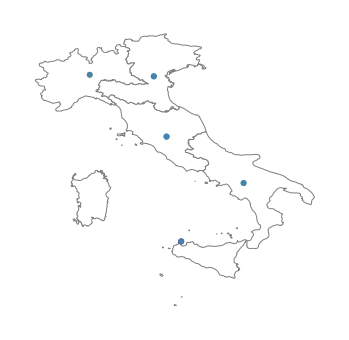

In [453]:
ax11 = gplt.pointplot(provinces_gdf_macroregion_sum_gdf, hue='Population')
gplt.pointplot(region_centroid, ax=ax11)
gplt.polyplot(macro_geometries, facecolor='white', edgecolor='grey', ax=ax11)

In [ ]:
# find actual centroids of each region

## Centroids Attempt 2

### Regions

#### geographic center 

In [341]:
prov_count = provinces_gdf.groupby('Region').name.count()

In [345]:
prov_geo_center_lat_lon_sum = provinces_gdf.groupby('Region')['Centroid_lat', 'Centroid_lon'].sum()

In [346]:
prov_geo_center_lat_lon_sum['geo_lat'] = prov_geo_center_lat_lon_sum['Centroid_lat'] / prov_count

In [348]:
prov_geo_center_lat_lon_sum['geo_lon'] = prov_geo_center_lat_lon_sum['Centroid_lon'] / prov_count

In [360]:
# prov_geo_center_lat_lon_sum
prov_geo_center_lat_lon_sum['Centroid_Coords'] = list(zip(prov_geo_center_lat_lon_sum['geo_lat'], 
                                                   prov_geo_center_lat_lon_sum['geo_lon']))
prov_geo_center_lat_lon_sum['geometry'] = [Point(x) for x in prov_geo_center_lat_lon_sum['Centroid_Coords']]

In [361]:
prov_geo_center_lat_lon_sum_gdf = gpd.GeoDataFrame(prov_geo_center_lat_lon_sum)

#### Plot

<AxesSubplot:>

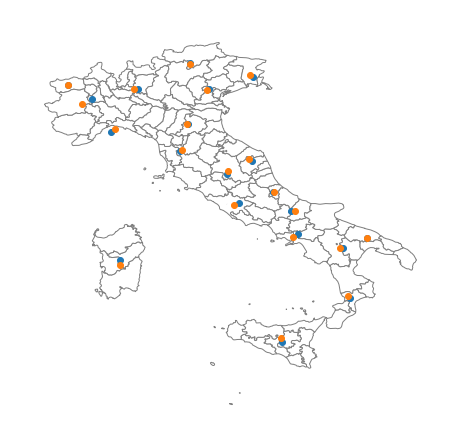

In [368]:
# I believe orange is population weighted 
# blue is geographic center
ax10 = prov_geo_center_lat_lon_sum_gdf.plot(figsize=(8,8))
region_weighted_centroid_gdf.plot(figsize=(8,8), ax=ax10)
gplt.polyplot(provinces_gdf, facecolor='white', edgecolor='grey', ax=ax10, figsize=(8,8))

In [370]:
prov_geo_center_lat_lon_sum_gdf['Population_weighted_centroid'] = region_weighted_centroid_gdf.geometry

In [371]:
prov_geo_center_lat_lon_sum_gdf['Distance'] = prov_geo_center_lat_lon_sum_gdf.geometry.distance(
    prov_geo_center_lat_lon_sum_gdf['Population_weighted_centroid'])

In [379]:
max_distance = prov_geo_center_lat_lon_sum_gdf.Distance.max()
prov_geo_center_lat_lon_sum_gdf[prov_geo_center_lat_lon_sum_gdf['Distance'] == max_distance]

,Centroid_lat,Centroid_lon,geo_lat,geo_lon,Centroid_Coords,geometry,Population_weighted_centroid,Distance
Region,,,,,,,,
Piedmont,65.035826,362.101893,8.129478,45.262737,"(8.129478250884207, 45.26273666471713)",POINT (8.12948 45.26274),POINT (7.79121 45.11496),0.369143


### Macroregions

#### Geographic Center

In [369]:
# dissolve and then centroid for geometry right? 

In [438]:
macro_geometries['geometry']

Macroregion
Centre        MULTIPOLYGON (((13.41896 40.79560, 13.42416 40...
Insular       MULTIPOLYGON (((12.62176 35.50975, 12.62127 35...
North-East    MULTIPOLYGON (((12.49074 43.96504, 12.48919 43...
North-West    POLYGON ((7.50229 43.79222, 7.48273 43.84022, ...
South         MULTIPOLYGON (((16.57349 38.46733, 16.56959 38...
Name: geometry, dtype: geometry

In [425]:
Geographic_center = macro_geometries['geometry'].centroid

In [406]:
# macro_geometries = pd.DataFrame(data = Geographic_center, index=macro_geometries.index, columns = ['geometry'])

In [427]:
macro_geo_center = pd.DataFrame(data = Geographic_center, index=macro_geometries.index, columns = ['geometry'])

In [429]:
macro_geo_center_gdf = gpd.GeoDataFrame(macro_geo_center)

#### Plot

<AxesSubplot:>

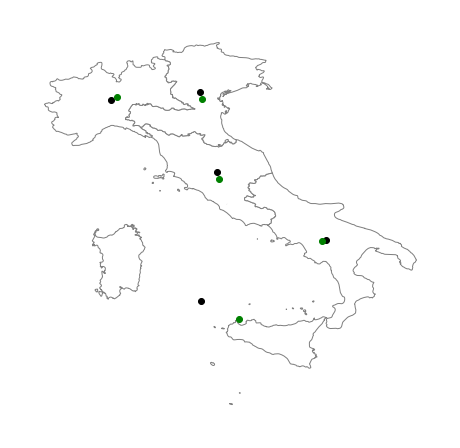

In [466]:
# green is population center while black is geo center
ax12 = macro_geo_center_gdf.plot(color='black', figsize=(8,8))
provinces_gdf_macroregion_sum_gdf.plot(figsize=(8,8), ax=ax12, color='green')
gplt.polyplot(macro_geometries, facecolor='white', edgecolor='grey', ax=ax12, figsize=(8,8))

In [473]:
# more ppl in sicily than sardinia?
prov_pop_sum = provinces_gdf.groupby('Region')['Population'].sum()
print(f"The population of sicily: {prov_pop_sum['Sicily']}")
print(f"The population of sardinia: {prov_pop_sum['Sardinia']}")
prov_pop_sum['Sicily'] - prov_pop_sum['Sardinia']

The population of sicily: 4999891
The population of sardinia: 1780437


3219454

### 3 Regions of Italy 

Mapping the population centroid of Italy using the 3 main regions: north, center, south

In [ ]:
# changing the "macroregion catego

### All of Italy

In [475]:
provinces_gdf['Country'] = 'Italy'

In [476]:
provinces_gdf_italy_sum = provinces_gdf.groupby('Country')['Population', 'Lat_times_weight', 'Lon_times_weight'].sum()

In [477]:
provinces_gdf_italy_sum['Lat_centroid'] = provinces_gdf_italy_sum['Lat_times_weight'] / \
                                                provinces_gdf_italy_sum['Population']
provinces_gdf_italy_sum['Lon_centroid'] = provinces_gdf_italy_sum['Lon_times_weight'] / \
                                                provinces_gdf_italy_sum['Population']

In [478]:
provinces_gdf_italy_sum['Centroid_Coords'] = list(zip(provinces_gdf_italy_sum['Lat_centroid'], 
                                                   provinces_gdf_italy_sum['Lon_centroid']))
provinces_gdf_italy_sum['geometry'] = [Point(x) for x in provinces_gdf_italy_sum['Centroid_Coords']]

In [479]:
provinces_gdf_italy_sum_gdf = gpd.GeoDataFrame(provinces_gdf_italy_sum, geometry='geometry')

In [480]:
provinces_gdf_italy_sum_gdf.head(2)

,Population,Lat_times_weight,Lon_times_weight,Lat_centroid,Lon_centroid,Centroid_Coords,geometry
Country,,,,,,,
Italy,60500383,7.297516e+08,2.597829e+09,12.061933,42.939056,"(12.061933242704367, 42.93905581590078)",POINT (12.06193 42.93906)


In [481]:
italy_geometry = provinces_gdf.dissolve(by='Country')

In [482]:
italy_geo_centroid = italy_geometry.geometry.centroid

#### Plot

In [ ]:
ax12 = macro_geo_center_gdf.plot(color='black', figsize=(8,8))
provinces_gdf_macroregion_sum_gdf.plot(figsize=(8,8), ax=ax12, color='green')
gplt.polyplot(macro_geometries, facecolor='white', edgecolor='grey', ax=ax12, figsize=(8,8))

<AxesSubplot:>

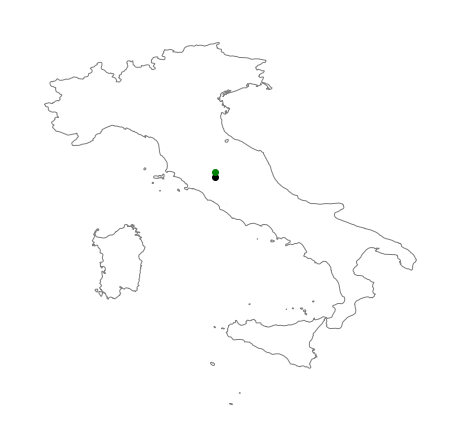

In [486]:
ax6 = italy_geo_centroid.plot(color='black', figsize=(8,8))
provinces_gdf_italy_sum_gdf.plot(ax=ax6, color='green', figsize=(8,8))
gplt.polyplot(italy_geometry, facecolor='white', edgecolor='grey', ax=ax6, figsize=(8,8))

##### Find which region this point lands in

In [498]:
italy_geo_center_point = italy_geo_centroid.geometry[0]
italy_pop_centroid = provinces_gdf_italy_sum_gdf.geometry[0]

In [502]:
# the mean population center of italy is within perugia
for index,x in provinces_gdf.iterrows():
    if x['Macroregion'] == 'Centre':
        if italy_geo_center_point.within(x['geometry']):
            print(f"Geographic center of italy is in the province of: {x['name']}")
        if italy_pop_centroid.within(x['geometry']):
            print(f"Population center of italy is in the province of: {x['name']}")

Population center of italy is in the province of: Perugia
Geographic center of italy is in the province of: Terni


In [504]:
terni_gdf = provinces_gdf[provinces_gdf['Province'] == 'Terni']
perugia_gdf = provinces_gdf[provinces_gdf['Province'] == 'Perugia']

<AxesSubplot:>

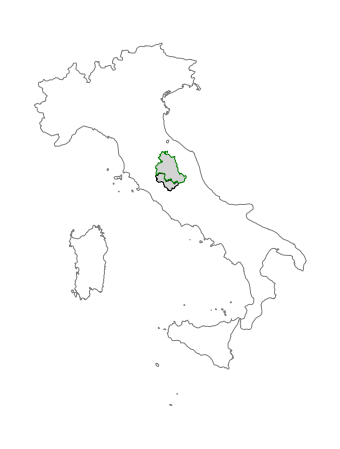

In [515]:
# plotting the regions too
ax6 = gplt.polyplot(italy_geometry, facecolor='white', edgecolor='grey', figsize=(8,8))
italy_geo_centroid.plot(color='black', figsize=(8,8), ax=ax6)
terni_gdf.plot(ax=ax6, color='lightgrey', edgecolor = 'black', figsize=(8,8))
perugia_gdf.plot(ax=ax6, color='lightgrey', edgecolor = 'green', figsize=(8,8))
# provinces_gdf_italy_sum_gdf.plot(ax=ax6, color='green', figsize=(8,8))
# ax6 = gplt.polyplot(italy_geometry, facecolor='white', edgecolor='grey', ax=ax6, figsize=(8,8))